In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)



### 1\. Análise Exploratória Rápida

In [6]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

# Carrega o conjunto de dados de treinamento
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# Agora sim, conte as ocorrências
target, counts = np.unique(newsgroups_train.target, return_counts=True)
target_names = newsgroups_train.target_names

for name, count in zip(target_names, counts):
    print(f"{name}: {count}")

alt.atheism: 480
comp.graphics: 584
comp.os.ms-windows.misc: 591
comp.sys.ibm.pc.hardware: 590
comp.sys.mac.hardware: 578
comp.windows.x: 593
misc.forsale: 585
rec.autos: 594
rec.motorcycles: 598
rec.sport.baseball: 597
rec.sport.hockey: 600
sci.crypt: 595
sci.electronics: 591
sci.med: 594
sci.space: 593
soc.religion.christian: 599
talk.politics.guns: 546
talk.politics.mideast: 564
talk.politics.misc: 465
talk.religion.misc: 377


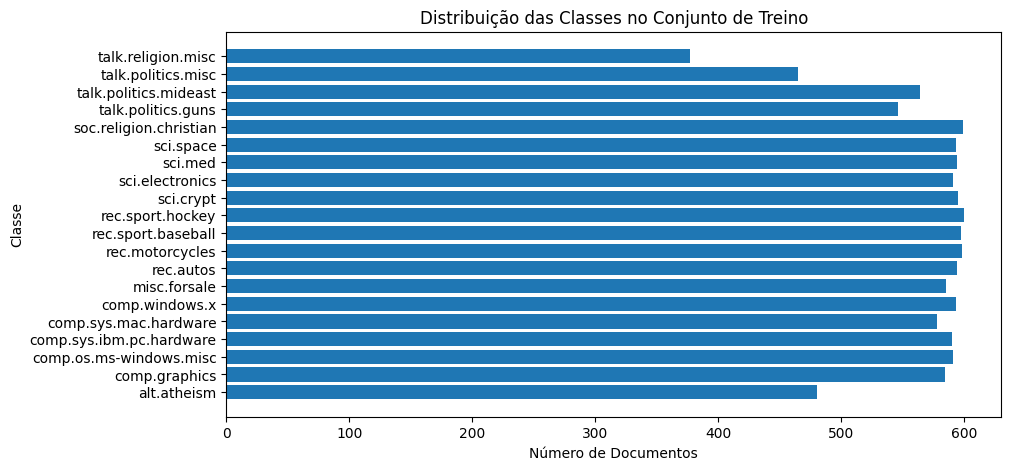

In [3]:
# Verificação do Balanceamento das Classes

import numpy as np
import matplotlib.pyplot as plt

# Contar as ocorrências de cada classe nos dados de treino
target, counts = np.unique(newsgroups_train.target, return_counts=True)
target_names = newsgroups_train.target_names

# Plotar o balanceamento
plt.figure(figsize=(10, 5))
plt.barh([target_names[i] for i in target], counts)
plt.title('Distribuição das Classes no Conjunto de Treino')
plt.xlabel('Número de Documentos')
plt.ylabel('Classe')
plt.show()

# Análise:
# O dataset '20 Newsgroups' é conhecido por ser razoavelmente balanceado,
# o que é ótimo. Se uma classe tivesse muito menos exemplos,
# o modelo poderia ter dificuldade em aprendê-la, e a acurácia
# não seria uma métrica tão confiável.

-----

### 2\. Otimização de Hiperparâmetros (Grid Search)


In [4]:
# Otimização com Pipeline e GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline # Usar Pipeline em vez de make_pipeline para nomear os passos

# 1. Definir a Pipeline
# Damos nomes aos passos ('vect' para vetorizador, 'clf' para classificador)
# Isso é necessário para o GridSearchCV
pipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB()),
])

# 2. Definir o Grid de Parâmetros para Otimizar
# Vamos testar diferentes combinações de parâmetros:
# vect__ngram_range: (1, 1) usa só palavras, (1, 2) usa palavras E bigramas (ex: "computer science")
# vect__max_df/min_df: Limites de frequência de termos
# clf__alpha: Parâmetro de suavização (Laplace/Lidstone) do Naive Bayes.
#             1.0 é o padrão (Laplace). Valores menores dão mais peso aos dados.

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_df': [0.75, 1.0],
    'vect__min_df': [1, 5],
    'clf__alpha': [0.01, 0.1, 1.0]
}

# 3. Instanciar o GridSearchCV
# cv=5 significa 5-fold cross-validation
# n_jobs=-1 usa todos os processadores disponíveis para acelerar
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

print("Iniciando a otimização de hiperparâmetros (Grid Search)...")
# Treinar o Grid Search nos dados de treino
grid_search.fit(newsgroups_train.data, newsgroups_train.target)

print("Otimização concluída!")
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# O 'model' agora é o melhor modelo encontrado pelo GridSearch
model = grid_search.best_estimator_

Iniciando a otimização de hiperparâmetros (Grid Search)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Otimização concluída!

Melhores parâmetros encontrados:
{'clf__alpha': 0.01, 'vect__max_df': 0.75, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}


-----

### 3\. Avaliação do Modelo Otimizado

Fazendo predições com o modelo otimizado nos dados de teste...

--- Relatório de Classificação (Dados de Teste) ---
                          precision    recall  f1-score   support

             alt.atheism       0.85      0.84      0.84       319
           comp.graphics       0.71      0.71      0.71       389
 comp.os.ms-windows.misc       0.71      0.66      0.68       394
comp.sys.ibm.pc.hardware       0.65      0.72      0.68       392
   comp.sys.mac.hardware       0.82      0.81      0.81       385
          comp.windows.x       0.81      0.79      0.80       395
            misc.forsale       0.80      0.81      0.81       390
               rec.autos       0.88      0.89      0.89       396
         rec.motorcycles       0.93      0.95      0.94       398
      rec.sport.baseball       0.93      0.92      0.92       397
        rec.sport.hockey       0.93      0.96      0.95       399
               sci.crypt       0.86      0.92      0.89       396
         sci.electronics 

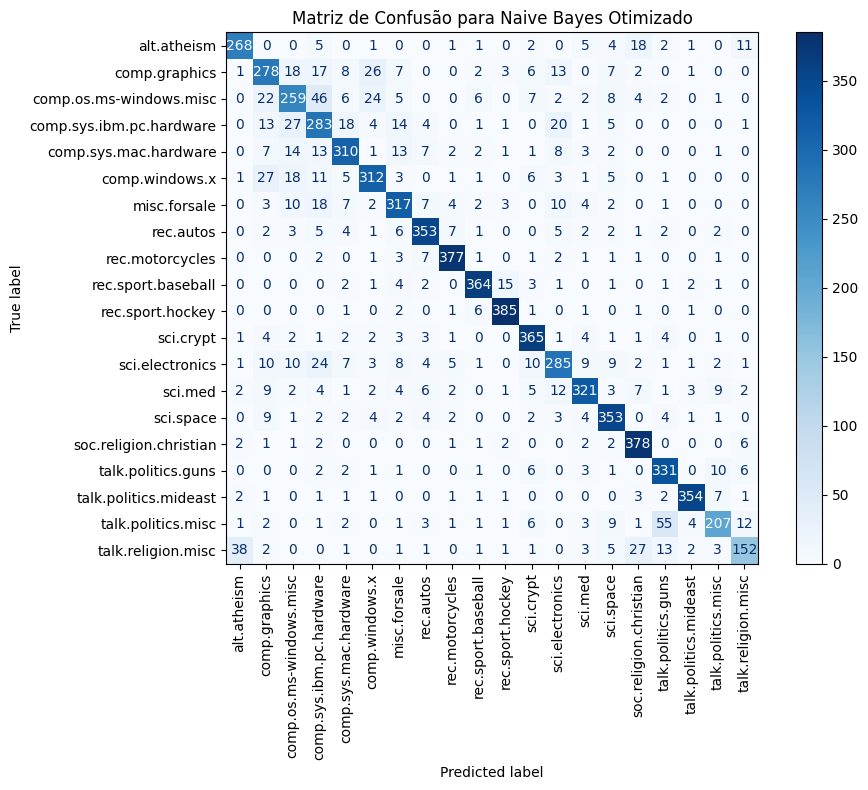

In [7]:
# Avaliação do Modelo Otimizado

print("Fazendo predições com o modelo otimizado nos dados de teste...")
# Usamos o grid_search para prever, ele automaticamente usa o best_estimator_
predictions = grid_search.predict(newsgroups_test.data)

print("\n--- Relatório de Classificação (Dados de Teste) ---")
print(classification_report(newsgroups_test.target, predictions, target_names=newsgroups_train.target_names))

# Comparar scores de treino e teste
# .score() no grid_search também usa o melhor modelo
train_accuracy = grid_search.score(newsgroups_train.data, newsgroups_train.target)
test_accuracy = grid_search.score(newsgroups_test.data, newsgroups_test.target)

print("\n--- Verificação de Overfitting (Acurácia) ---")
print(f"Acurácia nos dados de treino: {train_accuracy:.4f}")
print(f"Acurácia nos dados de teste:  {test_accuracy:.4f}")
print(f"(Acurácia do 'melhor' modelo encontrado durante o cross-validation: {grid_search.best_score_:.4f})")


# Plotar Matriz de Confusão
print("\n--- Matriz de Confusão (Modelo Otimizado) ---")
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(newsgroups_test.target, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=newsgroups_train.target_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
ax.set_title("Matriz de Confusão para Naive Bayes Otimizado")
plt.tight_layout()
plt.show()

-----

### 4\. Comparação com Outro Modelo

O Naive Bayes é um *baseline*. Como ele se compara a um modelo mais avançado? O `LinearSVC` (Support Vector Machine) é frequentemente um dos melhores classificadores "clássicos" para texto.


### 4.6 Comparação com um Modelo Baseline (LinearSVC)

O Naive Bayes é um ótimo ponto de partida, mas como ele se compara a outros classificadores? Vamos treinar um **Support Vector Machine (LinearSVC)**, que é conhecido por seu forte desempenho em classificação de texto, usando os mesmos dados.

Não faremos um GridSearch completo nele por questões de tempo, mas usaremos parâmetros padrão razoáveis.


In [8]:
# Treinando um LinearSVC como comparação

from sklearn.svm import LinearSVC

# Criar uma pipeline para o LinearSVC (SVM)
# Usaremos os mesmos parâmetros do TfidfVectorizer do nosso melhor NB
# (ou poderíamos usar os padrões)
best_vect_params = grid_search.best_estimator_.named_steps['vect']

svc_pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words='english',
        ngram_range=best_vect_params.ngram_range,
        max_df=best_vect_params.max_df,
        min_df=best_vect_params.min_df
    ),
    LinearSVC(random_state=42) # SVM
)

print("Iniciando o treinamento do LinearSVC...")
svc_pipeline.fit(newsgroups_train.data, newsgroups_train.target)
print("Treinamento do LinearSVC concluído.")

# Avaliar o LinearSVC
svc_test_accuracy = svc_pipeline.score(newsgroups_test.data, newsgroups_test.target)

print("\n--- Comparação de Acurácia nos Dados de Teste ---")
print(f"Naive Bayes Otimizado: {test_accuracy:.4f}")
print(f"LinearSVC (Baseline):   {svc_test_accuracy:.4f}")

# Você provavelmente verá que o LinearSVC tem um desempenho superior,
# o que é comum para esta tarefa. Isso valida o Naive Bayes como
# um 'baseline' rápido e decente, mas não necessariamente o melhor.

Iniciando o treinamento do LinearSVC...
Treinamento do LinearSVC concluído.

--- Comparação de Acurácia nos Dados de Teste ---
Naive Bayes Otimizado: 0.8301
LinearSVC (Baseline):   0.8566
